# Test code of GCTF Function

## Dependent Packages Installation

In [ ]:
if (!requireNamespace("rTensor", quietly = TRUE)){
    install.packages("rTensor")
}
if (!requireNamespace("testthat", quietly = TRUE)){
    install.packages("testthat")
}
if (!requireNamespace("einsum", quietly = TRUE)) {
    install.packages("einsum")
}

library("rTensor")
library("testthat")
library("einsum")

## GCTF Function (Paste your GCTF code here)

In [2]:
GCTF <- function(X, R, M=NULL, initZ=NULL, fix=NULL, Ranks, Beta=1,
                 num.iter=30, thr=1E-10, verbose=FALSE) {
  ######################################
  # Argument Check
  ######################################
  # Sign
  .checkSign(X)
  # Common Name
  .checkCommonName(X, R, Ranks)
  # Number of iteration
  .checkNumIteration(num.iter)
  # Threshold value
  .checkThreshold(thr)
  # Ranks
  .checkRanks(X, R, Ranks)
  # Size of X and M
  M <- .checkM(X, M)
  # Initial Latent Indices
  Z <- .checkInitZ(X, R, Ranks, initZ)
  # If fix is not set, all Z may be changed
  if (is.null(fix)) fix <- rep(FALSE, length(Z))

  ######################################
  # Setting
  ######################################
  # Visible Indices e.g. I, J, K, P, Q
  visibleIdxs <- .visibleIdxs(X)
  # Latent Indices e.g. p, q, r
  latentIdxs <- .latentIdxs(Ranks, Z, visibleIdxs)
  # Reconstruction Error
  RecError = c()
  # Relative Change
  RelChange = c()
  # Reconstructed Tensor
  X_bar <- .recTensor(X, Z, R, Ranks, latentIdxs)
  # First iteration
  RecError[1] <- .recError(X, X_bar)
  RelChange[1] <- thr * 10

  ######################################
  # Iteration
  ######################################
  iter <- 1
  while ((RelChange[iter] > thr) && (iter < num.iter)) {
    if (verbose) {
      cat(paste0("## Iteration: ", iter, "\n"))
    }
    # Update each Factor Matrix
    for (Alpha in seq_len(ncol(R))) {        
      # Skip update if current Alpha is set fixed.
      if (fix[Alpha]) next
      # Update factor matrix
      Z[[Alpha]] <- .MU(Z, M, X, X_bar, R, Alpha, Beta, Ranks)
      # Reconstruct observational tensor
      X_bar <- .recTensor(X, Z, R, Ranks, latentIdxs)
    }
    # After Update
    iter <- iter + 1      
    RecError[iter] <- .recError(X, X_bar)
    RelChange[iter] <- .relChange(iter, RecError)
  }
    
  # Output
  list(X=X, 
       Z=Z,
       R=R, Ranks=Ranks, Beta=Beta,
       num.iter=num.iter, thr=thr,
       RecError=RecError, RelChange=RelChange)
}

# Argument Check Functions
.checkSign <- function(X) {
  lapply(X, function(x) {
    if (!all(x >= 0)) {
      stop("Specify the input X as non-negative")
    }
  })
}

.checkCommonName <- function(X, R, Ranks) {
  if (!all(rownames(R) %in% names(X))) {
    stop("rownames(R) must be the same as names(X)")
  }
  if (!all(colnames(R) %in% names(Ranks))) {
    stop("rownames(R) must be the same as names(X)")
  }
  namesX <- unique(unlist(lapply(X, function(x){names(dim(x))})))
  namesRanks <- unique(unlist(lapply(Ranks, names)))
  if (!all(namesX %in% namesRanks)) {
    stop("rownames(R) must be the same as names(X)")
  }
}

.checkNumIteration <- function(num.iter) {
  if (num.iter <= 0) {
    stop("Specify num.iter as positive integar (e.g. 100)")
  }
}

.checkThreshold <- function(thr) {
  if (thr <= 0) {
    stop("Specify thr as positive real number (e.g. 1E-10)")
  }
}

.checkRanks <- function(X, R, Ranks) {
  Dims <- lapply(X, function(x){dim(x)})
  lapply(seq_len(ncol(R)), function(x) {
    objects <- rownames(R)[which(R[,x] == 1)]
    if(min(unlist(Dims[objects])) < min(unlist(Ranks[x]))){
      stop(paste0("Specify the Ranks[", x, "] as smaller value"))
    }
  })
}

.checkM <- function(X, M) {
  if (!is.null(M)) {
    if (!identical(lapply(X, dim), lapply(M, dim))) {
      stop("Dimension of Mask tensor M must be the same as that of X")
    }
  } else {
    M <- X
    for (i in seq_along(M)) {
      M[[i]][] <- 1
    }
  }
  M
}

.checkInitZ <- function(X, R, Ranks, initZ) {
  if (is.null(initZ)) {
    Z <- .genLatentVals(X, R, Ranks)
  } else {
    checkInitZ <- all(unlist(lapply(seq_along(initZ), function(x) {
      identical(as.integer(dim(initZ[[x]])),
                as.integer(unlist(Ranks[[x]])))
    })))
    if (!checkInitZ) {
      stop("The size of initZ must be same as the way Ranks specified")
    } else {
      Z <- initZ
    }
  }
  Z
}

# Visible Indices
.visibleIdxs <- function(X) {
  vnames <- unique(unlist(lapply(X, function(x) {
    names(dim(x))
  })) )
  vdims <- unlist(lapply(X, function(x) {
    dim(x)
  }))
  names(vdims) <- gsub(".*\\.", "", names(vdims))
  vdims <- vdims[vnames]
  vdims
}

# Latent indices
.latentIdxs <- function(Ranks, Z, visibleIdxs) {
  lnames <- unique(unlist(lapply(Ranks, function(x) {
    names(x)
  })))
  lnames <- setdiff(lnames, names(visibleIdxs))
  ldims <- unlist(lapply(Z, function(x) {
    dim(x)
  }))
  names(ldims) <- gsub(".*\\.", "", names(ldims))
  ldims <- ldims[lnames]
  ldims
}

# Multiplicate Update
.MU <- function(Z, M, X, X_bar, R, Alpha, Beta, Ranks) {
  # Numerator
  numer <- vapply(seq_len(nrow(R)), function(v) {
    R[v, Alpha] * .TensorValdFunc(M[[v]] *
                                    X_bar[[v]]^(-Beta) * X[[v]], Z, R, v, Alpha, Ranks)
  }, Z[[Alpha]])
  # Denominator
  denom <- vapply(seq_len(nrow(R)), function(v) {
    R[v, Alpha] * .TensorValdFunc(M[[v]] * X_bar[[v]]^(1-Beta),
                                  Z, R, v, Alpha, Ranks)
  }, Z[[Alpha]])
  # Update rules for GCTF
  sumRange <- seq_len(length(dim(numer)) - 1)
  out <- Z[[Alpha]] * (apply(numer, sumRange, sum) / apply(denom, sumRange, sum))
  out
}

.checkDimNames <- function(tensorList) {
    for (tensor in tensorList) {
        for (dimName in names(dim(tensor))) {
            # check if length of dimName is 1
            stopifnot(nchar(dimName) == 1)
        }        
    }
}

.generateEquationStringLeftHandSide <- function(tensorList) {
    equation <- ""
    for (iTensor in seq_along(tensorList)) {
        tensor <- tensorList[[iTensor]]
        for (dimName in names(dim(tensor))) {
            equation <- paste0(equation, dimName)
        }
        if (iTensor != length(tensorList)) {
            equation <- paste0(equation, ",")
        }
    }
    equation
}

.generateEquationStringRightHandSide <- function(marginNames) {
    equation <- ""
    for (dimName in marginNames) {
        equation <- paste0(equation, dimName)
    }
    equation
}

.generateEquationString <- function(tensorList, marginNames) {
    .checkDimNames(tensorList)    
    lhs <- .generateEquationStringLeftHandSide(tensorList)
    rhs <- .generateEquationStringRightHandSide(marginNames)
    equation <- paste(lhs, rhs, sep="->")
    equation
}

.MulSumTensors <- function(tensorList, marginNames) {
    equation <- .generateEquationString(tensorList, marginNames)
    resultTensor <- do.call("einsum", c(equation, tensorList))
    names(dim(resultTensor)) <- marginNames
    resultTensor
}

# Tensor Valued Function
# ∆α,ν function is just computing a product of tensors
# and collapses this product over indices not appearing in Zα

# e.g.
# v = 1
# Q = M[[v]] * X_bar[[v]]^(-Beta) * X[[v]]
.TensorValdFunc <- function(Q, Z, R, v, Alpha, Ranks) {
  if(R[v, Alpha] == 0) {
    # Z[[Alpha]] for vapply
    out <- Z[[Alpha]]
  } else {
    notAlphas <- intersect(setdiff(seq_len(ncol(R)), Alpha),
                           which(R[v, ] == 1))
    multiplied_tensor_list <-lapply(notAlphas, function(notAlpha){Z[[notAlpha]]})
    multiplied_tensor_list[[length(multiplied_tensor_list)+1]] <- Q
    out <- .MulSumTensors(multiplied_tensor_list, names(dim(Z[[Alpha]])))
  }
    
  # Reordering
  out <- .reOrder(out, Z[[Alpha]])
  names(dim(out)) <- names(dim(Z[[Alpha]]))
  out
}

# Reconstruction Error
.recError <- function(X, X_bar) {
  v <- unlist(lapply(seq_len(length(X)), function(x) {
    X[[x]] - X_bar[[x]]
  }))
  sqrt(sum(v * v))
}

# Reconstructed Tensor
.recTensor <- function(X, Z, R, Ranks, latentIdxs) {
  # Matrix object Position
  matObject <- lapply(Z, is.matrix)
  names(matObject) <- names(Z)
  # Reconstruction
  X_bar <- .Xbar(R, Z, matObject, latentIdxs)
  # Fix the order of X_bar as same as that of X
  .reOrder(X_bar, X)
}

# Reconstructed Tensor
.Xbar <- function(R, Z, matObject, latentIdxs) {
  out <- lapply(seq_len(nrow(R)), function(x) {
    # Related Factor matrix/tensor
    relFactor <- names(R[x, ][which(R[x, ] == 1)])
    # Tensor object position
    l <- which(!unlist(matObject[relFactor]))
    # if Tensor is contained in Z
    if (length(l) != 0) {
      # If a tensor is seed
      seed <- Z[[names(l)]]
      relFactor <- setdiff(relFactor, names(l))
    } else {
      # If a matrix is seed
      if (length(latentIdxs) == 1) {
        seed <- .diagonalTensor(names(latentIdxs), latentIdxs,
                                length(relFactor))
      } else {
        firstPos <- relFactor[1]
        seed <- Z[firstPos][[1]]
        relFactor <- setdiff(relFactor, firstPos)
      }
    }
    for (i in relFactor) {
      seed <- .xtx(seed, Z[i][[1]])
    }
    seed
  })
  names(out) <- rownames(R)
  out
}

.diagonalTensor <- function(latentIdxs, len1, len2){
  out <- rTensor:::.superdiagonal_tensor(len2, len1)@data
  names(dim(out)) <- rep(latentIdxs, len2)
  out
}

# ??????
.reOrder <- function(X_bar, X) {
  X_barType <- is.array(X_bar)
  XType <- is.array(X)
  if (X_barType && XType) {
    X_bar <- list(X_bar)
    X <- list(X)
  }
  vapply(seq_along(X_bar), function(x) {
    Xdimnames <- names(dim(X[[x]]))
    X_barorder <- unlist(lapply(Xdimnames, function(xx) {
      which(xx == names(dim(X_bar[[x]])))
    }))
    X_bar[[x]] <<- aperm(X_bar[[x]], X_barorder)
    0L
  }, 0L)
  if (X_barType && XType) {
    X_bar <- X_bar[[1]]
  }
  X_bar
}

# Initial Latent Indices
.genLatentVals <- function(X, R, Ranks) {
  out <- lapply(names(Ranks), function(x) {
    tmp <- abs(rand_tensor(modes = unlist(Ranks[[x]]))@data)
    tmp <- tmp / norm(as.matrix(tmp), "F")
    names(dim(tmp)) <- names(Ranks[[x]])
    tmp
  })
  names(out) <- colnames(R)
  out
}

# Matrix/Tensor × Matrix/Tensor
.xtx <- function(A, B) {
  isTensorA <- length(dim(A)) > 2
  isTensorB <- length(dim(B)) > 2
  # A : Matrix, B : Matrix
  if(!isTensorA && !isTensorB){
    out <- .mtm(as.matrix(A), as.matrix(B))
  }
  # A : Matrix, B : Tensor
  if(!isTensorA && isTensorB){
    out <- .ttm(B, as.matrix(A))
  }
  # A : Tensor, B : Matrix
  if(isTensorA && !isTensorB){
    out <- .ttm(A, as.matrix(B))
  }
  # A : Tensor, B : Tensor
  if(isTensorA && isTensorB){
    out <- .ttt(A, B)
  }
  out
}

# Matrix × Matrix
.mtm <- function(A, B) {
  # common mode
  commonMode <- intersect(names(dim(A)), names(dim(B)))
  targetA <- vapply(commonMode, function(x) {
    which(names(dim(A)) == x)[1]
  }, 0L)
  targetB <- vapply(commonMode, function(x) {
    which(names(dim(B)) == x)[1]
  }, 0L)
  # not common mode
  ncModeA <- setdiff(seq_len(length(dim(A))), targetA)
  ncModeB <- setdiff(seq_len(length(dim(B))), targetB)
  if ((targetA == 1) && (targetB == 1)) {
    out <- t(A) %*% B
  }
  if ((targetA == 1) && (targetB == 2)) {
    out <- t(A) %*% t(B)
  }
  if ((targetA == 2) && (targetB == 1)) {
    out <- A %*% B
  }
  if ((targetA == 2) && (targetB == 2)) {
    out <- A %*% t(B)
  }
  names(dim(out))[1] <- names(dim(A))[ncModeA]
  names(dim(out))[2] <- names(dim(B))[ncModeB]
  out
}

# Tensor × Tensor
.ttt <- function(A, B) {
  # common mode
  commonMode <- intersect(names(dim(A)), names(dim(B)))
  targetA <- vapply(commonMode, function(x){
    which(names(dim(A)) == x)[1]
  }, 0L)
  targetB <- vapply(commonMode, function(x){
    which(names(dim(B)) == x)[1]
  }, 0L)
  # not common mode
  ncModeA <- setdiff(seq_len(length(dim(A))), targetA)
  ncModeB <- setdiff(seq_len(length(dim(B))), targetB)
  # Matricising
  mat_1 <- rTensor::unfold(as.tensor(A),
                           row_idx = ncModeA, col_idx = targetA)@data
  mat_2 <- rTensor::unfold(as.tensor(B),
                           row_idx = ncModeB, col_idx = targetB)@data
  # Matrix-times-matrix
  out <- mat_1 %*% t(mat_2)
  if(length(ncModeA) == 1){
    names(dim(out))[1] <- names(dim(A)[ncModeA])
  }
  if(length(ncModeB) == 1){
    names(dim(out))[2] <- names(dim(B)[ncModeB])
  }

  if (length(ncModeA) == 0 && length(ncModeB) > 0) {
    # if ncModeA is empty
    names(ncModeB) <- names(dim(B))[ncModeB]
    out <- array(out, dim(B)[ncModeB])
  } else if (length(ncModeB) == 0 && length(ncModeA) > 0) {
    # if ncModeB is empty
    names(ncModeA) <- names(dim(A))[ncModeA]
    out <- array(out, dim(A)[ncModeA])
  } else if (length(ncModeA) == 0 && length(ncModeB) == 0) {
    # if both ncMode1 and ncMode2 are empty
    out <- out
  } else if (length(ncModeA) == 1 && length(ncModeB) == 1) {
    # both ncMode1 and ncMode2 contains only one element
    names(dim(out)) <- c(names(dim(A))[ncModeA], names(dim(B))[ncModeB])
  } else {
    # both ncMode1 and ncMode2 contains elements
    out <- fold(
      out, row_idx=seq_along(ncModeA),
      col_idx=seq(from=length(ncModeA)+1, to=length(ncModeA)+length(ncModeB)),
      modes=c(ncModeA, ncModeB))
  }
  out
}

.ttm <- function(A, B){
    
  # common mode
  commonMode <- intersect(names(dim(A)), names(dim(B)))
  targetA <- vapply(commonMode, function(x) {
    which(names(dim(A)) == x)[1]
  }, 0L)
  targetB <- vapply(commonMode, function(x) {
    which(names(dim(B)) == x)[1]
  }, 0L)
  notComModeA <- setdiff(seq_len(length(dim(A))), targetA)
  notComModeB <- setdiff(seq_len(length(dim(B))), targetB)
  A <- aperm(A, c(targetA, notComModeA))
  B <- aperm(B, c(targetB, notComModeB))
  # Tensor-times-matrix
  out <- ttm(as.tensor(A), t(B), m=1) # need support for the case modes of A and B are same.
  out <- out@data
  names(dim(out))[1] <- names(dim(B)[2])
  vapply(2:length(dim(out)), function(x) {
    names(dim(out))[x] <<- names(dim(A)[x])
  }, "")  
  out
}

# Relative Change
.relChange <- function(iter, RecError){
  # abs(RecError[iter-1] - RecError[iter]) / RecError[iter]
  # remove abs because errors can be increased in IS divergence case.
  (RecError[iter-1] - RecError[iter]) / RecError[iter]
}

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

## Simulation Datasets

In [3]:
set.seed(123)

# I × J × K
X1 <- rand_tensor(modes = c(4, 5, 6))
X1 <- X1@data^2
names(dim(X1)) <- c("I", "J", "K")

# I × P
X2 <- matrix(runif(4 * 7), nrow=4, ncol=7)
names(dim(X2)) <- c("I", "M")

# J × Q
X3 <- matrix(runif(5 * 8), nrow=5, ncol=8)
names(dim(X3)) <- c("J", "N")

# Coupled Tensor/Matrix
X <- list(X1 = X1, X2 = X2, X3 = X3)

# Coupling matrix R（CP）
R_CP <- rbind(
    c(1,1,1,0,0),
    c(1,0,0,1,0),
    c(0,1,0,0,1)
)
rownames(R_CP) <- paste0("X", seq(3))
colnames(R_CP) <- LETTERS[seq(5)]

# Size of Factor matrices (CP)
Ranks_CP <- list(
    A=list(I=4, r=3),
    B=list(J=5, r=3),
    C=list(K=6, r=3),
    D=list(M=7, r=3),
    E=list(N=8, r=3))

# Coupling matrix R（Tucker）
R_Tucker <- rbind(
    c(1,1,1,1,0,0),
    c(1,0,0,0,1,0),
    c(0,1,0,0,0,1)
)
rownames(R_Tucker) <- paste0("X", seq(3))
colnames(R_Tucker) <- LETTERS[seq(6)]

# Size of Factor matrices (Tucker)
Ranks_Tucker <- list(
    A=list(I=4, p=3),
    B=list(J=5, q=4),
    C=list(K=6, r=3),
    D=list(p=3, q=4, r=3),
    E=list(M=7, p=3),
    F=list(N=8, q=4))

## Perform GCTF against Simulation Datasets

In [4]:
# CP
out.CP_EUC <- GCTF(X, R_CP, Ranks=Ranks_CP, Beta=0)
out.CP_KL <- GCTF(X, R_CP, Ranks=Ranks_CP, Beta=1)
out.CP_IS <- GCTF(X, R_CP, Ranks=Ranks_CP, Beta=2)

# Tucker
out.Tucker_EUC <- GCTF(X, R_Tucker, Ranks=Ranks_Tucker, Beta=0)
out.Tucker_KL <- GCTF(X, R_Tucker, Ranks=Ranks_Tucker, Beta=1)
out.Tucker_IS <- GCTF(X, R_Tucker, Ranks=Ranks_Tucker, Beta=2)

## Unit Tests by Synthetic datasets

In [5]:
# define `expect_all_*()` because `expect_*()` cannot check if multiple
# values are all the same.
expect_all_identical <- function(object, ...) {
    expects <- list(...)
    for (expect in expects) {
        expect_identical(object, expect)
    }    
}
expect_all_equal <- function(object, ...) {
    expects <- list(...)
    for (expect in expects) {
        expect_equal(object, expect)
    }    
}
expect_all_equivalent <- function(object, ...) {
    expects <- list(...)
    for (expect in expects) {
        expect_equivalent(object, expect)
    }    
}

# # Success
# expect_all_identical(0, 0, 0)
# expect_all_equal(0, as.integer(0), 0)
#
# # Fail
# expect_all_identical(0, as.integer(0), 0)

### Test Input object / type

#### Test I-1: Object Names

In [6]:
expect_identical(names(formals(GCTF)), c("X", "R", "M", "initZ", "fix", "Ranks", "Beta", "num.iter", "thr", "verbose"))

#### Test I-2: X

In [7]:
expect_identical(as.character(formals(GCTF)$X), "")

#### Test I-3: R

In [8]:
expect_identical(as.character(formals(GCTF)$R), "")

#### Test I-4: M

In [9]:
expect_identical(formals(GCTF)$M, NULL)

#### Test I-5: initZ

In [10]:
expect_identical(formals(GCTF)$initZ, NULL)

#### Test I-6: fix

In [11]:
expect_identical(formals(GCTF)$fix, NULL)

#### Test I-7: Ranks

In [12]:
expect_identical(as.character(formals(GCTF)$Ranks), "")

#### Test I-8: Beta

In [13]:
expect_identical(formals(GCTF)$Beta, 1)

#### Test I-9: num.iter

In [14]:
expect_identical(formals(GCTF)$num.iter, 30)

#### Test I-10: thr

In [15]:
expect_identical(formals(GCTF)$thr, 1E-10)

#### Test I-11: verbose

In [16]:
expect_identical(formals(GCTF)$verbose, FALSE)

### Test Output object / type

#### Test O-1: Object

In [17]:
# CP
expect_identical(is.list(out.CP_EUC), TRUE)
expect_identical(is.list(out.CP_KL), TRUE)
expect_identical(is.list(out.CP_IS), TRUE)

# Tucker
expect_identical(is.list(out.Tucker_EUC), TRUE)
expect_identical(is.list(out.Tucker_KL), TRUE)
expect_identical(is.list(out.Tucker_IS), TRUE)

#### Test O-2: Object Names

In [18]:
# CP
expect_identical(names(out.CP_EUC), c("X", "Z", "R", "Ranks", "Beta", "num.iter", "thr", "RecError", "RelChange"))
expect_identical(names(out.CP_KL), c("X", "Z", "R", "Ranks", "Beta", "num.iter", "thr", "RecError", "RelChange"))
expect_identical(names(out.CP_IS), c("X", "Z", "R", "Ranks", "Beta", "num.iter", "thr", "RecError", "RelChange"))

# Tucker
expect_identical(names(out.Tucker_EUC), c("X", "Z", "R", "Ranks", "Beta", "num.iter", "thr", "RecError", "RelChange"))
expect_identical(names(out.Tucker_KL), c("X", "Z", "R", "Ranks", "Beta", "num.iter", "thr", "RecError", "RelChange"))
expect_identical(names(out.Tucker_IS), c("X", "Z", "R", "Ranks", "Beta", "num.iter", "thr", "RecError", "RelChange"))

#### Test O-3: X

In [19]:
# CP
expect_identical(out.CP_EUC$X, X)
expect_identical(out.CP_KL$X, X)
expect_identical(out.CP_IS$X, X)

# Tucker
expect_identical(out.Tucker_EUC$X, X)
expect_identical(out.Tucker_KL$X, X)
expect_identical(out.Tucker_IS$X, X)

#### Test O-4: Z

In [20]:
# CP
expect_identical(is.list(out.CP_EUC$Z), TRUE)
expect_identical(is.list(out.CP_KL$Z), TRUE)
expect_identical(is.list(out.CP_IS$Z), TRUE)

# Tucker
expect_identical(is.list(out.Tucker_EUC$Z), TRUE)
expect_identical(is.list(out.Tucker_KL$Z), TRUE)
expect_identical(is.list(out.Tucker_IS$Z), TRUE)

#### Test O-5: R

In [21]:
# CP
expect_identical(out.CP_EUC$R, R_CP)
expect_identical(out.CP_KL$R, R_CP)
expect_identical(out.CP_IS$R, R_CP)

# Tucker
expect_identical(out.Tucker_EUC$R, R_Tucker)
expect_identical(out.Tucker_KL$R, R_Tucker)
expect_identical(out.Tucker_IS$R, R_Tucker)

#### Test O-6: Rank

In [22]:
# CP
expect_identical(out.CP_EUC$Ranks, Ranks_CP)
expect_identical(out.CP_KL$Ranks, Ranks_CP)
expect_identical(out.CP_IS$Ranks, Ranks_CP)

# Tucker
expect_identical(out.Tucker_EUC$Ranks, Ranks_Tucker)
expect_identical(out.Tucker_KL$Ranks, Ranks_Tucker)
expect_identical(out.Tucker_IS$Ranks, Ranks_Tucker)

#### Test O-7: Beta

In [23]:
# CP
expect_identical(out.CP_EUC$Beta, 0)
expect_identical(out.CP_KL$Beta, 1)
expect_identical(out.CP_IS$Beta, 2)

# Tucker
expect_identical(out.Tucker_EUC$Beta, 0)
expect_identical(out.Tucker_KL$Beta, 1)
expect_identical(out.Tucker_IS$Beta, 2)

#### Test O-8: num.iter

In [24]:
# CP
expect_identical(out.CP_EUC$iter, formals(GCTF)$iter)
expect_identical(out.CP_KL$iter, formals(GCTF)$iter)
expect_identical(out.CP_IS$iter, formals(GCTF)$iter)

# Tucker
expect_identical(out.Tucker_EUC$iter, formals(GCTF)$iter)
expect_identical(out.Tucker_KL$iter, formals(GCTF)$iter)
expect_identical(out.Tucker_IS$iter, formals(GCTF)$iter)

#### Test O-9: thr

In [25]:
# CP
expect_identical(out.CP_EUC$thr, formals(GCTF)$thr)
expect_identical(out.CP_KL$thr, formals(GCTF)$thr)
expect_identical(out.CP_IS$thr, formals(GCTF)$thr)

# Tucker
expect_identical(out.Tucker_EUC$thr, formals(GCTF)$thr)
expect_identical(out.Tucker_KL$thr, formals(GCTF)$thr)
expect_identical(out.Tucker_IS$thr, formals(GCTF)$thr)

#### Test O-10: RecError

In [26]:
# CP
expect_identical(is.vector(out.CP_EUC$RecError), TRUE)
expect_identical(is.vector(out.CP_KL$RecError), TRUE)
expect_identical(is.vector(out.CP_IS$RecError), TRUE)

# Tucker
expect_identical(is.vector(out.Tucker_EUC$RecError), TRUE)
expect_identical(is.vector(out.Tucker_KL$RecError), TRUE)
expect_identical(is.vector(out.Tucker_IS$RecError), TRUE)

#### Test O-11: RelChange

In [27]:
# CP
expect_identical(is.vector(out.CP_EUC$RelChange), TRUE)
expect_identical(is.vector(out.CP_KL$RelChange), TRUE)
expect_identical(is.vector(out.CP_IS$RelChange), TRUE)

# Tucker
expect_identical(is.vector(out.Tucker_EUC$RelChange), TRUE)
expect_identical(is.vector(out.Tucker_KL$RelChange), TRUE)
expect_identical(is.vector(out.Tucker_IS$RelChange), TRUE)

### Test Non-negative data

#### Test NN-1: X

In [28]:
NegativeX <- X
NegativeX$X2[2, 3] <- -1
expect_error(GCTF(NegativeX, R_CP, Ranks=Ranks_CP, Beta=0))

### Test Consistency of Objects

#### Test C-1: X and Z

In [29]:
# CP
## I
expect_all_identical(
    dim(X$X1)[1],
    dim(X$X2)[1],
    dim(out.CP_EUC$Z$A)[1],
    dim(out.CP_KL$Z$A)[1],
    dim(out.CP_IS$Z$A)[1])
## J
expect_all_identical(
    dim(X$X1)[2],
    dim(X$X3)[1],
    dim(out.CP_EUC$Z$B)[1],
    dim(out.CP_KL$Z$B)[1],
    dim(out.CP_IS$Z$B)[1])
## K
expect_all_identical(
    dim(X$X1)[3],
    dim(out.CP_EUC$Z$C)[1],
    dim(out.CP_KL$Z$C)[1],
    dim(out.CP_IS$Z$C)[1])
## M
expect_all_identical(
    dim(X$X2)[2],
    dim(out.CP_EUC$Z$D)[1],
    dim(out.CP_KL$Z$D)[1],
    dim(out.CP_IS$Z$D)[1])
## N
expect_all_identical(
    dim(X$X3)[2],
    dim(out.CP_EUC$Z$E)[1],
    dim(out.CP_KL$Z$E)[1],
    dim(out.CP_IS$Z$E)[1])

# Tucker
## I
expect_all_identical(
    dim(X$X1)[1],
    dim(X$X2)[1],
    dim(out.Tucker_EUC$Z$A)[1],
    dim(out.Tucker_KL$Z$A)[1],
    dim(out.Tucker_IS$Z$A)[1])
## J
expect_all_identical(
    dim(X$X1)[2],
    dim(X$X3)[1],
    dim(out.Tucker_EUC$Z$B)[1],
    dim(out.Tucker_KL$Z$B)[1],
    dim(out.Tucker_IS$Z$B)[1])
## K
expect_all_identical(
    dim(X$X1)[3],
    dim(out.Tucker_EUC$Z$C)[1],
    dim(out.Tucker_KL$Z$C)[1],
    dim(out.Tucker_IS$Z$C)[1])
## M
expect_all_identical(
    dim(X$X2)[2],
    dim(out.Tucker_EUC$Z$E)[1],
    dim(out.Tucker_KL$Z$E)[1],
    dim(out.Tucker_IS$Z$E)[1])
## N
expect_all_identical(
    dim(X$X3)[2],
    dim(out.Tucker_EUC$Z$F)[1],
    dim(out.Tucker_KL$Z$F)[1],
    dim(out.Tucker_IS$Z$F)[1])

#### Test C-2: X and M

In [30]:
# Expect no error when partially masked some rows
M <- X
M$X1 <- M$X1 * 0 + 1
# Mask only rows 1:3
M$X2 <- M$X2 * 1; M$X2[1:3, 1:7] <- 0  
M$X3 <- M$X3 * 0 + 1
expect_error(
    GCTF(X=X, R=R_CP, M=M, Ranks=Ranks_CP, Beta=0),
    regexp=NA)  # regexp=NA means "there should be no errors"

# Expect error when completely masked some columns
M <- X
M$X1 <- M$X1 * 0 + 1
# Mask some column
M$X2 <- M$X2 * 1; M$X2[1:4, 7] <- 0
M$X3 <- M$X3 * 0 + 1
expect_error(GCTF(X=X, R=R_CP, M=M, Ranks=Ranks_CP, Beta=0))

# Expect error when completely masked
M <- X
M$X1 <- M$X1 * 0 + 1
# Mask all rows (1:4)
M$X2 <- M$X2 * 1; M$X2[1:4, 1:7] <- 0
M$X3 <- M$X3 * 0 + 1
expect_error(GCTF(X=X, R=R_CP, M=M, Ranks=Ranks_CP, Beta=0))

#### Test C-3: Rank and Z

In [31]:
# CP
## A
expect_all_equal(
    unlist(Ranks_CP$A),
    dim(out.CP_EUC$Z$A),
    dim(out.CP_KL$Z$A),
    dim(out.CP_IS$Z$A))
## B
expect_all_equal(
    unlist(Ranks_CP$B),
    dim(out.CP_EUC$Z$B),
    dim(out.CP_KL$Z$B),
    dim(out.CP_IS$Z$B))
## C
expect_all_equal(
    unlist(Ranks_CP$C),
    dim(out.CP_EUC$Z$C),
    dim(out.CP_KL$Z$C),
    dim(out.CP_IS$Z$C))
## D
expect_all_equal(
    unlist(Ranks_CP$D),
    dim(out.CP_EUC$Z$D),
    dim(out.CP_KL$Z$D),
    dim(out.CP_IS$Z$D))
## E
expect_all_equal(
    unlist(Ranks_CP$E),
    dim(out.CP_EUC$Z$E),
    dim(out.CP_KL$Z$E),
    dim(out.CP_IS$Z$E))

# Tucker
## A
expect_all_equal(
    unlist(Ranks_Tucker$A),
    dim(out.Tucker_EUC$Z$A),
    dim(out.Tucker_KL$Z$A),
    dim(out.Tucker_IS$Z$A))
## B
expect_all_equal(
    unlist(Ranks_Tucker$B),
    dim(out.Tucker_EUC$Z$B),
    dim(out.Tucker_KL$Z$B),
    dim(out.Tucker_IS$Z$B))
## C
expect_all_equal(
    unlist(Ranks_Tucker$C),
    dim(out.Tucker_EUC$Z$C),
    dim(out.Tucker_KL$Z$C),
    dim(out.Tucker_IS$Z$C))
## E
expect_all_equal(
    unlist(Ranks_Tucker$E),
    dim(out.Tucker_EUC$Z$E),
    dim(out.Tucker_KL$Z$E),
    dim(out.Tucker_IS$Z$E))
## F
expect_all_equal(
    unlist(Ranks_Tucker$F),
    dim(out.Tucker_EUC$Z$F),
    dim(out.Tucker_KL$Z$F),
    dim(out.Tucker_IS$Z$F))

#### Test C-4: num.iter, RecError, and RelChange

In [32]:
# CP
expect_all_equal(
    formals(GCTF)$num.iter,
    length(out.CP_EUC$RecError),
    length(out.CP_KL$RecError),
    # length(out.CP_IS$RecError),
    length(out.CP_EUC$RelChange),
    length(out.CP_KL$RelChange))
    # length(out.CP_IS$RelChange))

# Tucker
expect_all_equal(
    formals(GCTF)$num.iter,
    length(out.Tucker_EUC$RecError),
    length(out.Tucker_KL$RecError),
    # length(out.Tucker_IS$RecError),
    length(out.Tucker_EUC$RelChange),
    length(out.Tucker_KL$RelChange))
    # length(out.Tucker_IS$RelChange))

### Test Monotonous Decrease of Error

#### Test M-1: RecError

In [33]:
# CP
expect_identical(order(out.CP_EUC$RecError), rev(seq(30)))
expect_identical(order(out.CP_KL$RecError), rev(seq(30)))

# Not run: In IS case, computation may be unsteady.
# expect_identical(order(out.CP_IS$RecError), rev(seq(30)))

# Tucker
expect_identical(order(out.Tucker_EUC$RecError), rev(seq(30)))
expect_identical(order(out.Tucker_KL$RecError), rev(seq(30)))

# Not run: In IS case, computation may be unsteady.
# expect_identical(order(out.Tucker_IS$RecError), rev(seq(30)))

#### Test M-2: RelChange

In [34]:
# first element of RelChange doesn't have to be sequentially ordered.

# CP
expect_identical(order(out.CP_EUC$RelChange[2:30]), rev(seq(30-1)))
expect_identical(order(out.CP_KL$RelChange[2:30]), rev(seq(30-1)))
expect_identical(order(out.CP_IS$RelChange[2:30]), rev(seq(30-1)))

# Tucker
expect_identical(order(out.Tucker_EUC$RelChange[2:30]), rev(seq(30-1)))
expect_identical(order(out.Tucker_KL$RelChange[2:30]), rev(seq(30-1)))
expect_identical(order(out.Tucker_IS$RelChange[2:30]), rev(seq(30-1)))

ERROR: Error: order(out.CP_IS$RelChange[2:30]) not identical to rev(seq(30 - 1)).
28/29 mismatches (average diff: 15)
[1] 6 - 29 == -23
[2] 5 - 28 == -23
[3] 4 - 27 == -23
[4] 3 - 26 == -23
[5] 1 - 25 == -24
[6] 2 - 24 == -22
[7] 7 - 23 == -16
[8] 8 - 22 == -14
[9] 9 - 21 == -12
...


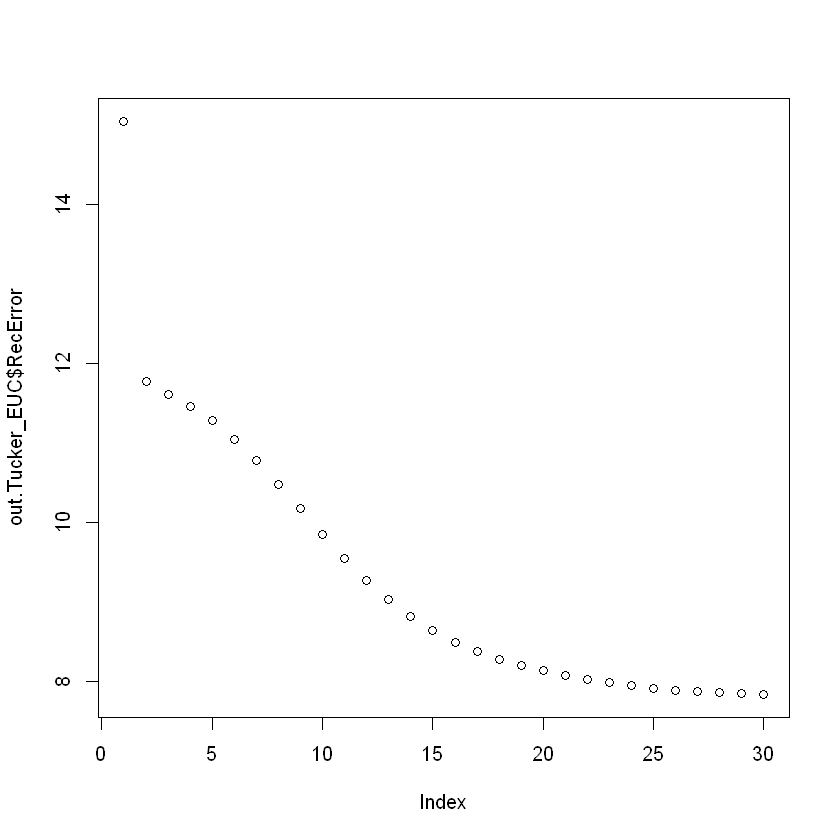

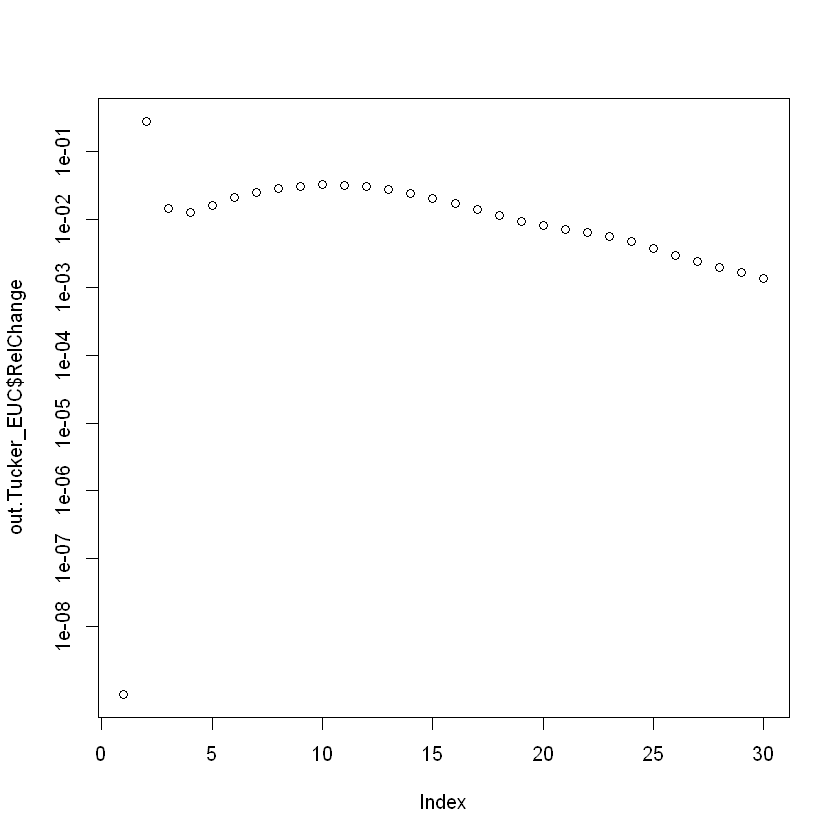

In [35]:
# Check RecError and RelChange of Tucker EUC
plot(out.Tucker_EUC$RecError)
plot(out.Tucker_EUC$RelChange, log="y")

### Test Estimates

#### Test E-1: CP/MF/MF

In [36]:
# The test in Yilmaz and Umut (2011) is performed using the synthetic data.
# No mentions about the scale in the article.
# This implementation compares the true and estimated Zs after normalization.

set.seed(123)

I_test = 30
J_test = 30
K_test = 30
M_test = 30
N_test = 30
r_test = 5
A_test = matrix(runif(I_test*r_test), I_test, r_test); names(dim(A_test)) <- c("I", "r")
B_test = matrix(runif(J_test*r_test), J_test, r_test); names(dim(B_test)) <- c("J", "r")
C_test = matrix(runif(K_test*r_test), K_test, r_test); names(dim(C_test)) <- c("K", "r")
D_test = matrix(runif(M_test*r_test), M_test, r_test); names(dim(D_test)) <- c("M", "r")
E_test = matrix(runif(N_test*r_test), N_test, r_test); names(dim(E_test)) <- c("N", "r")
Z_true <- list(A=A_test, B=B_test, C=C_test, D=D_test, E=E_test)
X1_test <- array(rep(0, I_test*J_test*K_test), dim=c(I_test, J_test, K_test)); names(dim(X1_test)) <- c("I", "J", "K")
for (i in 1:I_test) {
    for (j in 1:J_test) {
        for (k in 1:K_test) {
            X1_test[i, j, k] <- sum(A_test[i, ] * B_test[j, ] * C_test[k, ])
        }
    }
}
X2_test <- array(rep(0, I_test*M_test), dim=c(I_test, M_test)); names(dim(X2_test)) <- c("I", "M")
for (i in 1:I_test) {
    for (m in 1:M_test) {
        X2_test[i, m] <- sum(A_test[i, ] * D_test[m, ])
    }
}
X3_test <- array(rep(0, J_test*N_test), dim=c(J_test, N_test)); names(dim(X3_test)) <- c("J", "N")
for (j in 1:J_test) {
    for (n in 1:N_test) {
        X3_test[j, n] <- sum(B_test[j, ] * E_test[n, ])
    }
}
X_test <- list(X1=X1_test, X2=X2_test, X3=X3_test)

# Visible Indices e.g. I, J, K, P, Q
visibleIdxs_a <- .visibleIdxs(X_test)

# Latent Indices e.g. p, q, r
latentIdxs_a <- .latentIdxs(Ranks_CP, Z_true, visibleIdxs_a)
X_dummy <- X_test

Ranks_test <- list(
    A=list(I=I_test, r=r_test),
    B=list(J=J_test, r=r_test),
    C=list(K=K_test, r=r_test),
    D=list(M=M_test, r=r_test),
    E=list(N=N_test, r=r_test))

In [37]:
SolveOrthgonalProcrustes <- function(refrence, estimates) {
    # To find the correct permutation, for each of Z_alpha 
    # the matching permutation between the original and estimate found 
    # by solving an orthgonal Procrustes problem.
    svdResult <- svd(t(refrence) %*% estimates)
    rotation <- svdResult$u %*% t(svdResult$v)
    return(rotation)
}

RotateEstimates <- function(estimates, rotation) {
    return(estimates %*% t(rotation))
}

In [38]:
# These methods are used for Test E-1: CP/MF/MF
# GCTF doesn't use these methods.

.MulTensors <- function(tensorList) {    
    dims <- unlist(lapply(tensorList, function(x){dim(x)}))
    dimnames <- sort(unique(names(dims)))
    dims <- dims[dimnames]
    tensorListExpand <- lapply(tensorList, function(x){
        this_dims <- dim(x)
        this_dimnames <- names(this_dims)
        missing_dimnames <- setdiff(dimnames, this_dimnames)
        missing_dims <- dims[missing_dimnames]    
        new_x <- array(rep(x, prod(missing_dims)), c(this_dims, missing_dims))    
        new_x <- aperm(new_x, order(names(dim(new_x))))

        return(new_x)
    })
    tensorsProd <- 1
    for (tensorExpand in tensorListExpand) {
        tensorsProd <- tensorsProd * tensorExpand
    }
    tensorsProd
}

# Normalization
# compute normalized Z and scaling tensors Lambdas
.normalizeFactors <- function(Z, R, latentIdxs) {
    
    # normalize all factors. 
    # compute normalized factors and scaling tensors.
    
    # normalized factors:
    #   list. number of elements are same of Z.
    #   each elements are tensors.
    #   the shape of each elements are same of Zs.
    #
    # scaling tensors:
    #   list. number of eleme-nts are same of Z.
    #   each elements are tensors.
    #   the length of each elements are
    #   number of latent indice of each Zs elements.
    #   (for example, scaling tensor S1's shape is [p,q] if Z1 is shape[I,J,p,q])
    
    normalizedFactors <- list()
    scalingTensors <- list()
    
    # loop for each factors
    for (Alpha in seq_len(ncol(R))) {
        
        latentDimNamesOfZAlpha <- intersect(names(latentIdxs), names(dim(Z[[Alpha]])))
        latentIdxLocations <- which(names(dim(Z[[Alpha]])) %in% latentDimNamesOfZAlpha)
        latentDimNamesOfZAlpha <- names(dim(Z[[Alpha]]))[latentIdxLocations]

        if (length(latentDimNamesOfZAlpha) == 1) {
            scalingTensor <- as.array(apply(
                    Z[[Alpha]]^2,
                    which(names(dim(Z[[Alpha]])) %in% latentDimNamesOfZAlpha),
                sum)^(1/2))
            names(dim(scalingTensor)) <- latentDimNamesOfZAlpha
            normalizedFactor <- .MulTensors(list(Z[[Alpha]], 1 / scalingTensor))
        } else {
            scalingTensor <- sqrt(sum(Z[[Alpha]]^2))
            normalizedFactor <- Z[[Alpha]] / scalingTensor
        }        

        normalizedFactors[[length(normalizedFactors) + 1]] <- normalizedFactor
        scalingTensors[[length(scalingTensors) + 1]] <- scalingTensor
    }    
    # aggregate scaling tensors of factors into scaling tensors of observational tensors.
    
    # scaling tensors of observational tensors 
    #  ... list. number of elements are same of X.
    #      each elements are tensors.
    #      the dimensions of each elements(=tensor) are
    #      all latent indeice of its related factors.
    
    observationalScalingTensors <- list()
    
    for (v in seq_len(nrow(R))) {       
        scalingTensorsOfRelatedFactors <- list()        
        for (Alpha in seq_len(ncol(R))) {
            if (R[v, Alpha] == 1) {
                scalingTensorsOfRelatedFactors[[length(scalingTensorsOfRelatedFactors) + 1]] <- scalingTensors[[Alpha]]
            }
        }
        observationalScalingTensors[[length(observationalScalingTensors) + 1]] <- 
            .MulTensors(scalingTensorsOfRelatedFactors)
    }
    
    result <- list(
        normalizedFactors = normalizedFactors,
        observationalScalingTensors = observationalScalingTensors)
    
    names(result$normalizedFactors) <- names(Z)
    names(result$observationalScalingTensors) <- names(X)

    result
}

In [39]:
# generate initial Z
.initZ <- .genLatentVals(X_dummy, R_CP, Ranks_test)

# normalize initial Z
visibleIdxs <- .visibleIdxs(X_dummy)
latentIdxs <- .latentIdxs(Ranks_test, .initZ, visibleIdxs)
normalizedInitZ <- .normalizeFactors(.initZ, R_CP, latentIdxs)$normalizedFactors

In [40]:
# estimate Z
resultGCTF <- GCTF(
    X_dummy, R_CP, M=NULL, initZ=.initZ, fix=NULL,
    Ranks_test, Beta=1, num.iter=1000, thr=1E-10, verbose=FALSE)

In [41]:
# normalize estimated Z
normalizedEstimatedZ <- .normalizeFactors(resultGCTF$Z, R_CP, latentIdxs)$normalizedFactors

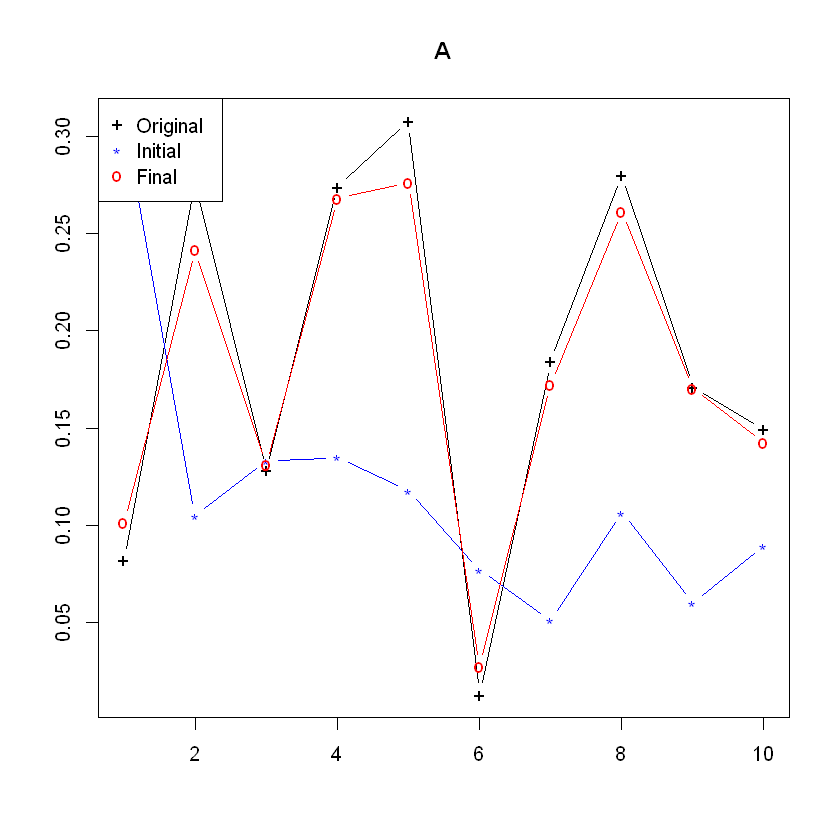

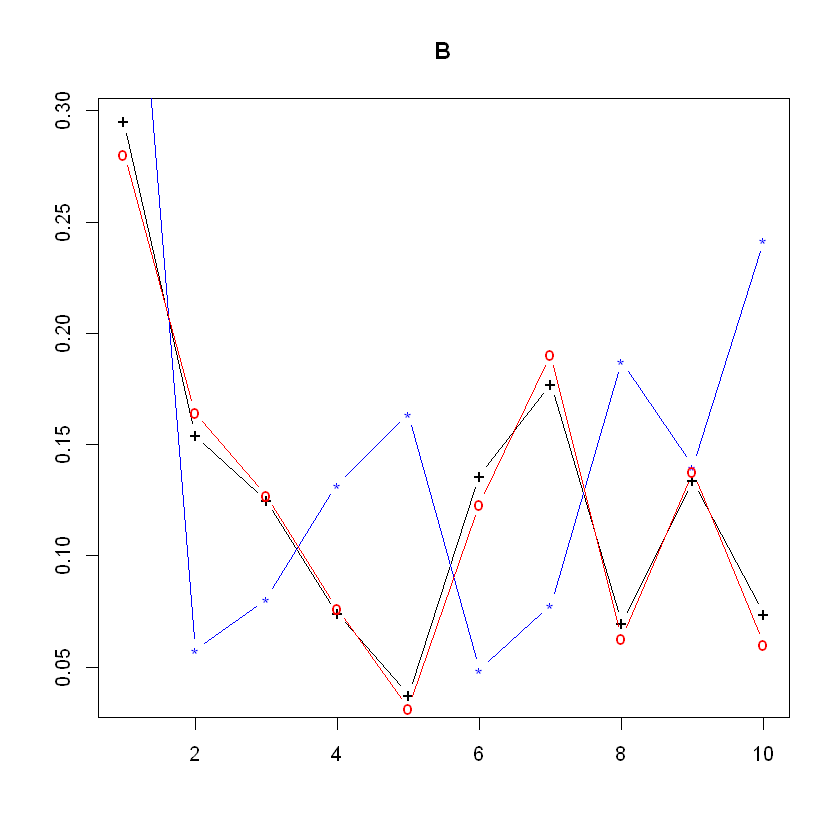

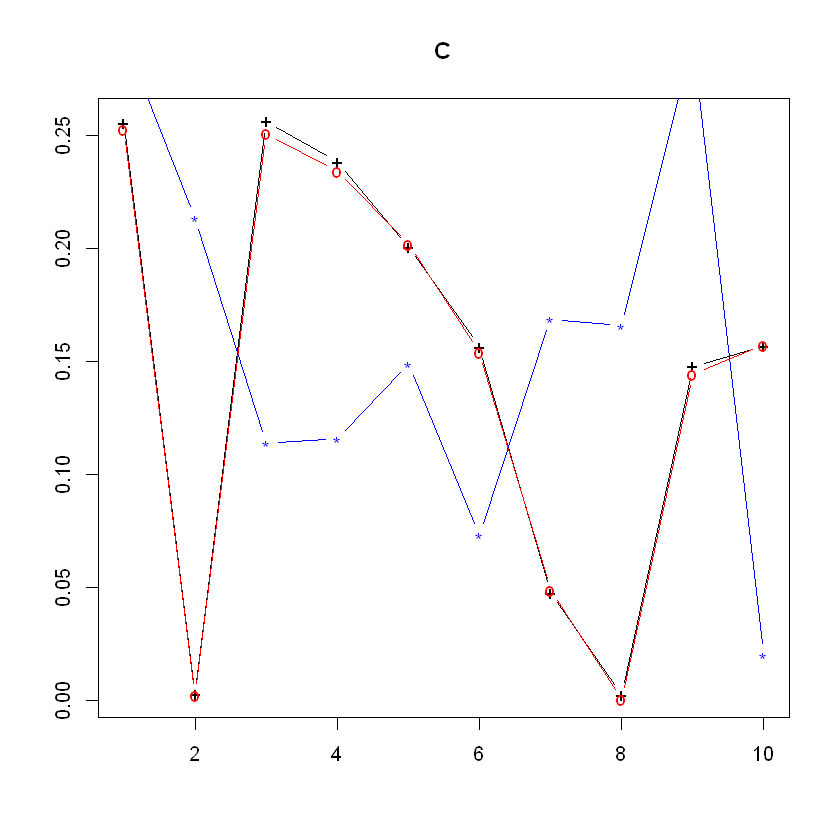

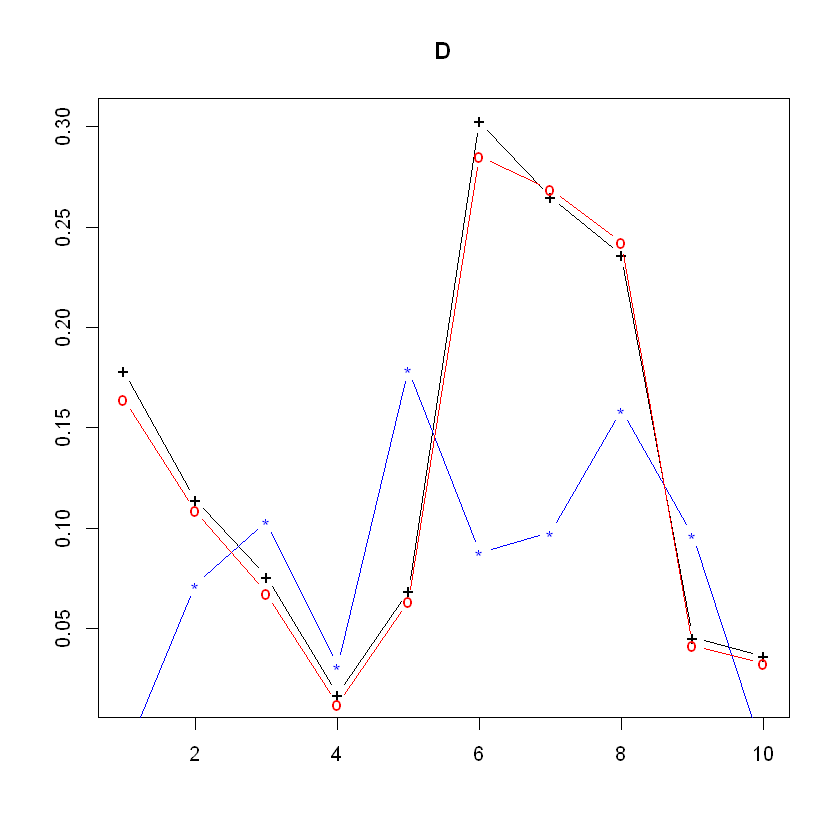

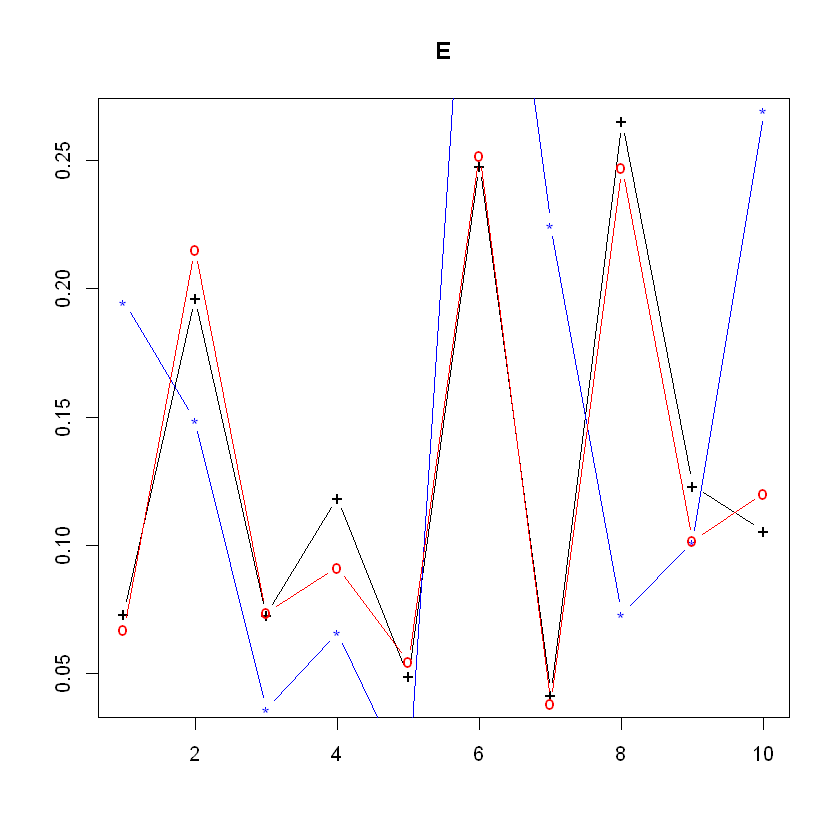

In [42]:
for (factorName in c("A", "B", "C", "D", "E")) {
    # plot answer
    plot(1:10, (Z_true[[factorName]] / sqrt(colSums(Z_true[[factorName]]^2)))[1:10, 1], type="b", col='black', pch="+", main=factorName, xlab="", ylab="")

    # rotate initial Z
    rotation <- SolveOrthgonalProcrustes(Z_true[[factorName]], normalizedInitZ[[factorName]])
    rotatedEstimates <- RotateEstimates(normalizedInitZ[[factorName]], rotation)

    # plot initial Z
    lines(1:10, rotatedEstimates[1:10, 1], type="b", col='blue', pch="*")

    # rotate estimated Z
    rotation <- SolveOrthgonalProcrustes(Z_true[[factorName]], normalizedEstimatedZ[[factorName]])
    rotatedEstimates <- RotateEstimates(normalizedEstimatedZ[[factorName]], rotation)

    # plot estimated Z
    lines(1:10, rotatedEstimates[1:10, 1], type="b", col='red', pch="o")
    
    if (factorName == 'A') {
        legend("topleft", 
               legend = c("Original", "Initial", "Final"),
               col = c("black", "blue", "red"),
               pch = c("+", "*", "o"))
    }
}

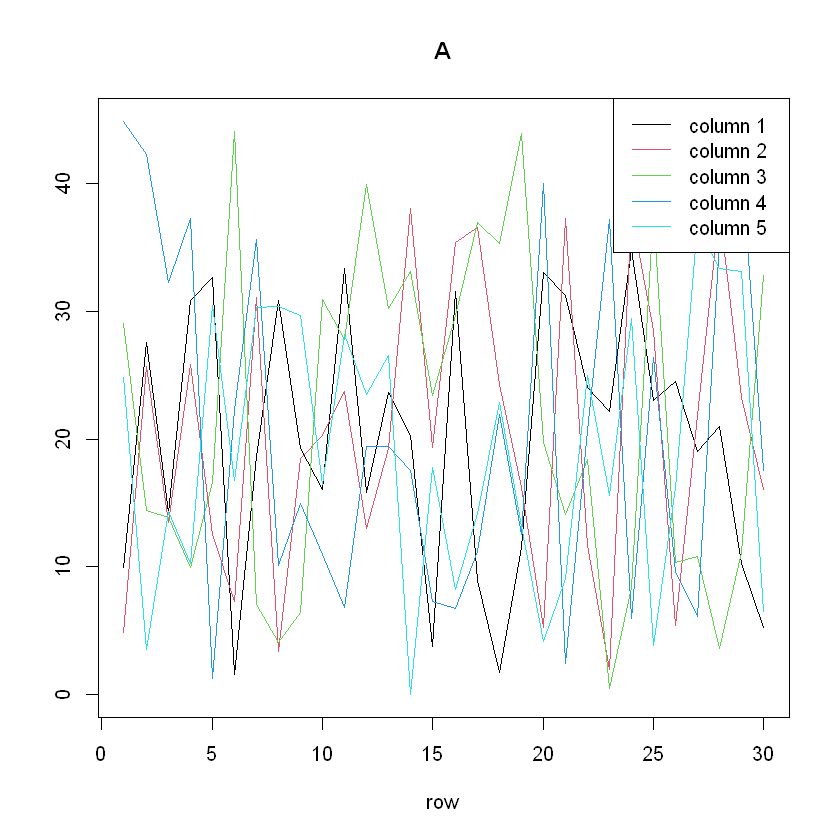

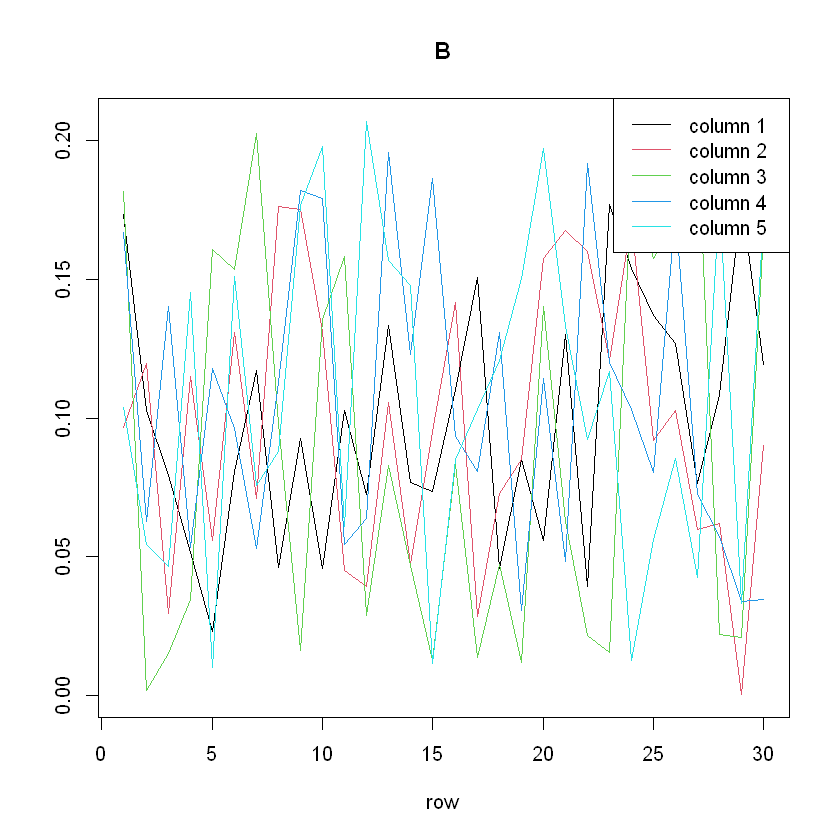

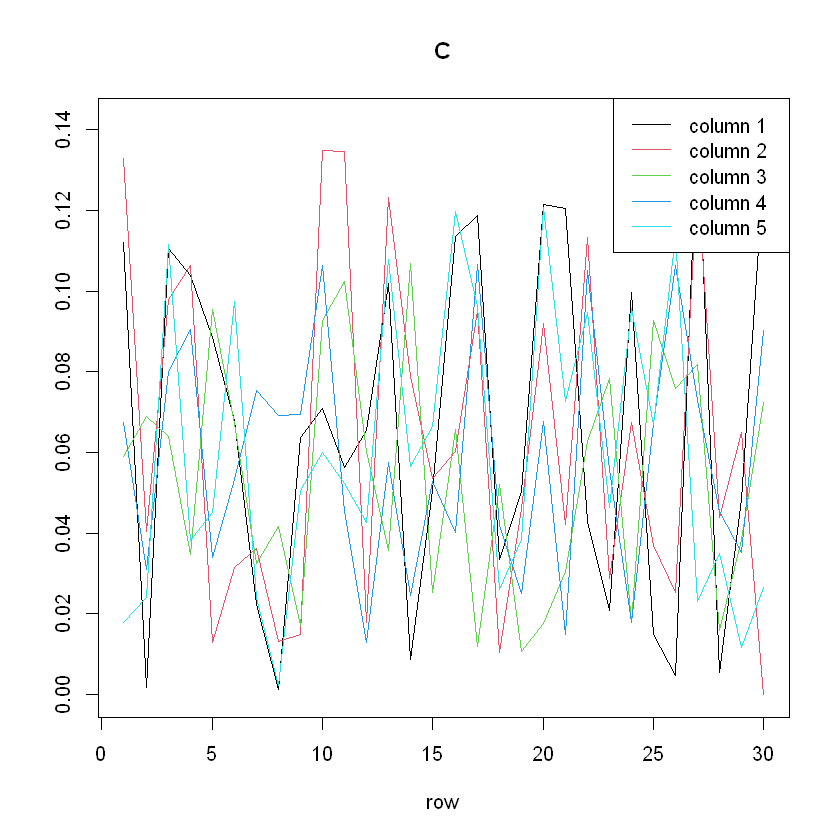

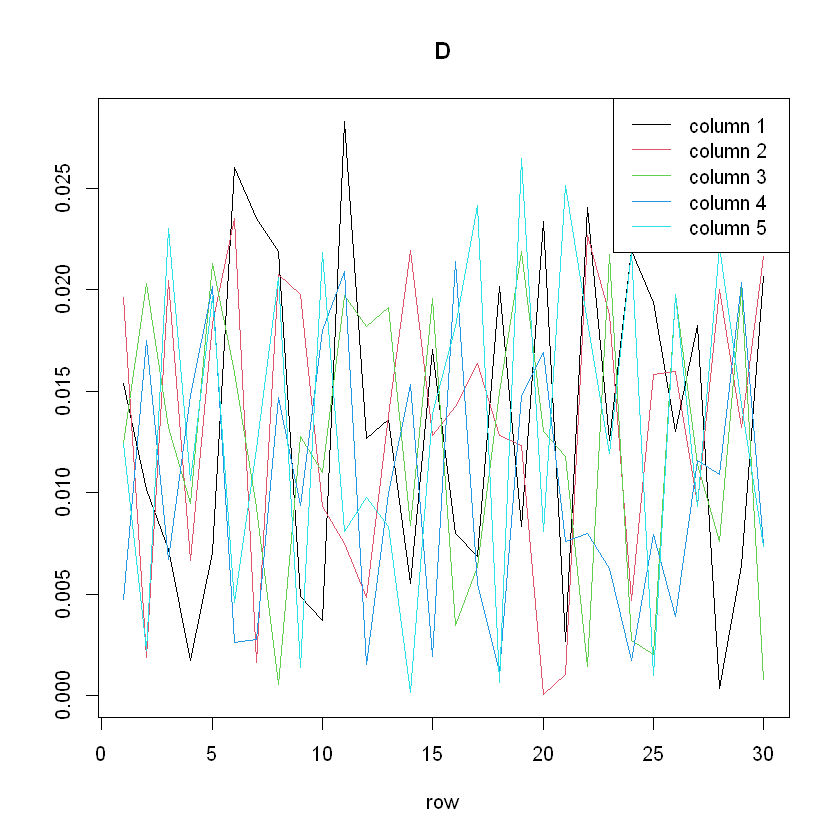

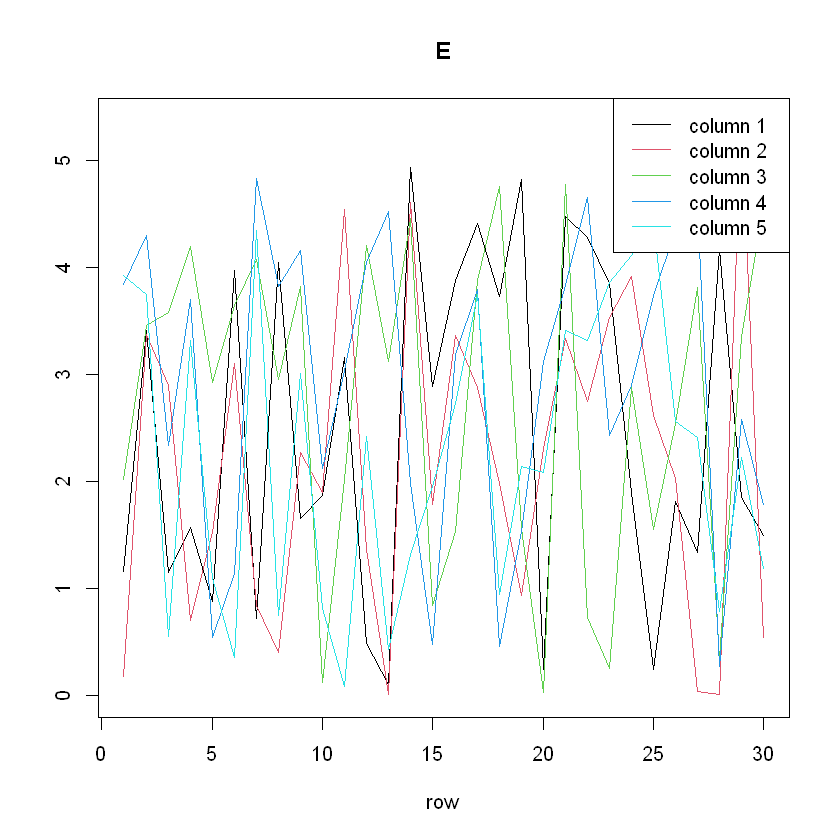

In [43]:
# Visualize estimated factors (not normalized)
# to check if underflow or overflow happens.
for (factorName in c("A", "B", "C", "D", "E")) {
    ts.plot(resultGCTF$Z[[factorName]], main=factorName, xlab="row", ylab="", col=1:ncol(resultGCTF$Z[[factorName]]))
    legend("topright", legend=paste("column", 1:ncol(resultGCTF$Z[[factorName]])), col=1:ncol(resultGCTF$Z[[factorName]]), lty=1, cex=1)
}

### Test Fixation of Z

In [44]:
fixAlphas <- c(TRUE, FALSE, TRUE, FALSE, FALSE)

resultGCTF <- GCTF(X_dummy, R_CP, M=NULL, initZ=NULL, fix=NULL, Ranks_test, Beta=1, num.iter=1, thr=1E-10, verbose=FALSE)
fixedA <- resultGCTF$Z$A
fixedC <- resultGCTF$Z$C
initial_Z <- resultGCTF$Z
initial_Z$A <- initial_Z$A * 0 + 0.1
initial_Z$C <- initial_Z$C * 0 + 0.2
resultGCTF <- GCTF(X_dummy, R_CP, M=NULL, initZ=initial_Z, fix=fixAlphas, Ranks_test, Beta=1, num.iter=10, thr=1E-10, verbose=FALSE)


In [45]:
expect_true(all(resultGCTF$Z$A == initial_Z$A))
expect_true(all(resultGCTF$Z$B != initial_Z$B))
expect_true(all(resultGCTF$Z$C == initial_Z$C))
expect_true(all(resultGCTF$Z$D != initial_Z$D))
expect_true(all(resultGCTF$Z$E != initial_Z$E))

## Session Information

In [46]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19044)

Matrix products: default

locale:
[1] LC_COLLATE=Japanese_Japan.932  LC_CTYPE=Japanese_Japan.932   
[3] LC_MONETARY=Japanese_Japan.932 LC_NUMERIC=C                  
[5] LC_TIME=Japanese_Japan.932    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] einsum_0.1.0   testthat_3.0.4 rTensor_1.4.8 

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.7      magrittr_2.0.1  pkgload_1.2.1   uuid_0.1-4     
 [5] R6_2.5.1        rlang_0.4.11    fastmap_1.1.0   fansi_0.5.0    
 [9] tools_4.1.0     waldo_0.3.0     utf8_1.2.2      withr_2.4.2    
[13] htmltools_0.5.2 ellipsis_0.3.2  rprojroot_2.0.2 digest_0.6.27  
[17] lifecycle_1.0.0 crayon_1.4.1    IRdisplay_1.0   repr_1.1.3     
[21] base64enc_0.1-3 vctrs_0.3.8     IRkernel_1.2    glue_1.4.2     
[25] evaluate_0.14   pbdZMQ_0.3-5    compiler_4.1.0